In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [3]:
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

In [5]:
def get_confusion_matrix(actual_y, predicted_y):
    '''
    Helper function to nicely print confusion matrix
    '''
    confusion_index =  ['Ad_Actual','Non-AD_Actual']
    confusion_cols = ['Ad_Predicted','Non-AD_Predicted']
    confusion_df = pd.DataFrame(confusion_matrix(actual_y, predicted_y), index = confusion_index, columns = confusion_cols)
    return confusion_df

In [6]:
%matplotlib inline
sns.set_style('white')

In [7]:
# set project path
proj_dir = '/Users/Gabi/dev/hedgeable/'
data_path = '/Users/Gabi/dev/hedgeable/data/'

## Section 1 - Data Pre-Processing Cleaning 

In [8]:
# read and apply column names from file
feature_names = pd.read_csv(data_path + 'column.names.txt', usecols =[0], delimiter =':', skip_blank_lines=True)
feature_names.columns = ['col_name']
feature_names=  feature_names.col_name.values.tolist()
feature_names.append('target')

In [9]:
# read data
dat = pd.read_csv(data_path + 'data', names = feature_names, index_col=False, header=0)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
dat.shape

(3278, 1559)

In [63]:
dat.to_csv(proj_dir + 'src/data_w_headers.csv')

In [11]:
dat.dtypes

height                       object
width                        object
aratio                       object
local                        object
url*images+buttons            int64
url*likesbooks.com            int64
url*www.slake.com             int64
url*hydrogeologist            int64
url*oso                       int64
url*media                     int64
url*peace+images              int64
url*blipverts                 int64
url*tkaine+kats               int64
url*labyrinth                 int64
url*advertising+blipverts     int64
url*images+oso                int64
url*area51+corridor           int64
url*ran+gifs                  int64
url*express-scripts.com       int64
url*off                       int64
url*cnet                      int64
url*time+1998                 int64
url*josefina3                 int64
url*truluck.com               int64
url*clawnext+gif              int64
url*autopen.com               int64
url*tvgen.com                 int64
url*pixs                    

In [12]:
# take a look at first 5 variables - Continuous variables should be numeric
vars_cont = ['height','width','aratio']

In [13]:
dat[vars_cont].apply(lambda x: x.value_counts()).head()

,height,width,aratio
?,NaN,NaN,910.0
0.5,NaN,NaN,9.0
0.8,NaN,NaN,4.0
0.9,NaN,NaN,2.0
1,1.0,2.0,NaN


In [14]:
'''
    Clean up 3 continuous variables:
        - Replace ? with NA 
        - strip balnks
        - convert to float
'''
dat[vars_cont]= dat[vars_cont].apply(lambda x: x.str.strip()).replace("?",np.nan).astype(np.float)

In [15]:
dat[vars_cont].describe()

,height,width,aratio
count,2375.000000,2377.000000,2368.000000
mean,63.996211,155.357594,3.913182
std,54.865881,130.058220,6.043966
min,1.000000,1.000000,0.001500
25%,25.000000,80.000000,1.036675
50%,51.000000,110.000000,2.106550
75%,85.000000,184.000000,5.333300
max,640.000000,640.000000,60.000000


In [16]:
# check other data types
print dat.select_dtypes(include = ['object']).columns
print dat.local.value_counts()

Index([u'local', u'target'], dtype='object')
1    1578
1     925
0     455
0     305
?      15
Name: local, dtype: int64


In [17]:
'''
    Clean up Local - this should be 0,1
        - Replace ? with 2 (unknown can be its own category)
        - Convert instances were there are strings for 0 and 1 to integers
'''
dat['local']= dat['local'].replace("?",2)
dat.loc[dat.local == '1','local'] = dat[dat.local == '1'].local.astype(np.int64)
dat.loc[dat.local == '0','local'] = dat[dat.local == '0'].local.astype(np.int64)

In [18]:
dat.local.value_counts()

1    2503
0     760
2      15
Name: local, dtype: int64

In [19]:
# check for missing data - only continuous variables 
dat.isnull().sum().sort_values(ascending = False).nlargest(10)

aratio                         910
height                         903
width                          901
origurl*coltrane                 0
origurl*ibitexas.com             0
origurl*wco.com                  0
origurl*jsd                      0
origurl*www.rock.n.roll.com      0
origurl*antiwar.com              0
origurl*target                   0
dtype: int64

In [20]:
# what does the rest of the data look like?
dat.describe()

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*of,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you
count,2375.000000,2377.000000,2368.000000,3278.000000,3278.000000,3278.000000,3278.000000,3278.000000,3278.000000,3278.000000,...,3278.000000,3278.000000,3278.000000,3278.000000,3278.000000,3278.000000,3278.000000,3278.000000,3278.000000,3278.000000
mean,63.996211,155.357594,3.913182,0.772727,0.004271,0.011592,0.004576,0.003356,0.003966,0.011592,...,0.006101,0.004576,0.003661,0.002441,0.003051,0.006406,0.012813,0.013423,0.009762,0.001525
std,54.865881,130.058220,6.043966,0.429916,0.065222,0.107059,0.067501,0.057840,0.062859,0.107059,...,0.077884,0.067501,0.060403,0.049349,0.055157,0.079795,0.112483,0.115094,0.098335,0.039032
min,1.000000,1.000000,0.001500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,80.000000,1.036675,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,51.000000,110.000000,2.106550,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,85.000000,184.000000,5.333300,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,640.000000,640.000000,60.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
'''
Take a look at binary features:
    Are there many features with all 0's? Yes and some features are almost 100% 0 values
    Are there many features with all 1's? Not as high percentages of total as 0's
    
    Maybe we can eliminate some of these if they dont add additional information to the model...
'''
n_rows = dat.shape[0]
cat_cols = dat.select_dtypes(include = ['int64']).columns
binary_counts = dat[cat_cols].apply(lambda x: x.value_counts()).T
binary_counts.sort_values(by =1, ascending=False, inplace=True)
binary_counts.head()

,0,1,2
local,760.0,2503.0,15.0
url*images,2334.0,944.0,NaN
origurl*www.geocities.com,2672.0,606.0,NaN
origurl*geocities.com,2672.0,606.0,NaN
url*geocities.com,2697.0,581.0,NaN


In [22]:
# let's see if there are any columns with only 0 or 1
binary_counts.describe()

,0,1,2
count,1555.000000,1555.000000,1.0
mean,3251.079743,26.910611,15.0
std,79.277116,78.974144,NaN
min,760.000000,4.000000,15.0
25%,3255.000000,11.000000,15.0
50%,3263.000000,15.000000,15.0
75%,3267.000000,23.000000,15.0
max,3274.000000,2503.000000,15.0


In [23]:
# these are features with mostly 0 values in column - maybe these wont be needed in the model?
pd.DataFrame(data = {'count_0':binary_counts[0].nlargest(20), 'perc_tot':binary_counts[0].nlargest(20)/n_rows}).head(10)

,count_0,perc_tot
ancurl*schwab,3274.0,0.998780
ancurl*bridalinfo,3273.0,0.998475
origurl*hist,3273.0,0.998475
ancurl*de,3273.0,0.998475
ancurl*slagen,3273.0,0.998475
ancurl*cuteftp,3273.0,0.998475
ancurl*excite+468x60,3273.0,0.998475
caption*you,3273.0,0.998475
ancurl*any+time,3272.0,0.998170
ancurl*ad+preferences,3272.0,0.998170


In [24]:
# these are features with mostly 1 values in column - less data with 1's than 0's
pd.DataFrame(data = {'count_1':binary_counts[1].nlargest(20), 'perc_tot':binary_counts[1].nlargest(20)/n_rows}).head(10)

,count_1,perc_tot
local,2503.0,0.763575
url*images,944.0,0.287980
origurl*www.geocities.com,606.0,0.184869
origurl*geocities.com,606.0,0.184869
url*geocities.com,581.0,0.177242
url*www.geocities.com,581.0,0.177242
ancurl*geocities.com,516.0,0.157413
ancurl*www.geocities.com,496.0,0.151312
ancurl*bin,369.0,0.112569
origurl*heartland,277.0,0.084503


## Section 2 - Data Exploration

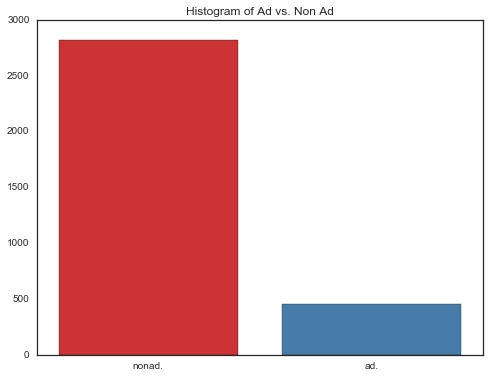

In [25]:
# Plot Ad vs Non Ad histogram
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (8,6));
data = dat.target.value_counts()
data= data.reset_index()

sns.barplot(data=data, y= 'target', x='index', palette='Set1', ax =ax);
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation = 0)
ax.set_title('Histogram of Ad vs. Non Ad')
ax.set_xlabel('')
ax.set_ylabel('')
plt.show(fig)

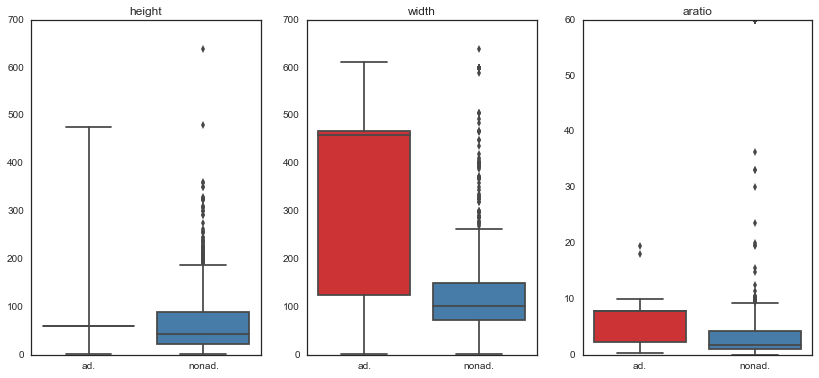

In [26]:
'''
    Box plots of continuous variables vs target
        - Need to scale height & width since these are not on the same scale
'''
var = ['height','width', 'aratio']
fig, axes = plt.subplots(figsize=(14, 6),ncols=3)
for i, v in enumerate(var):
    sns.boxplot(x = 'target', y =v, ax = axes[i], data=dat[[v, 'target']], palette='Set1')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(v)
plt.show(fig)

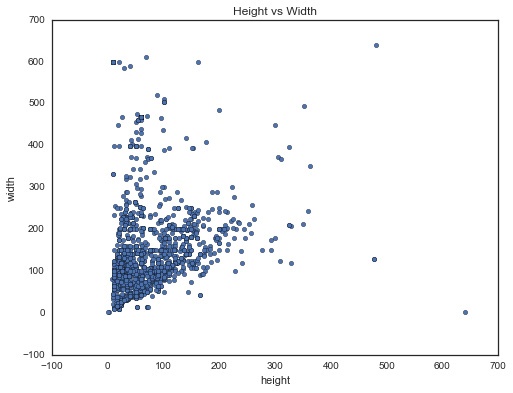

In [27]:
'''
    Relationship between height and width
        - Looks like there are a few outliers
'''

fig, ax = plt.subplots(figsize=(8, 6))
dat.plot.scatter(x = var[0], y = var[1],ax=ax, title = 'Height vs Width')
plt.show(fig)

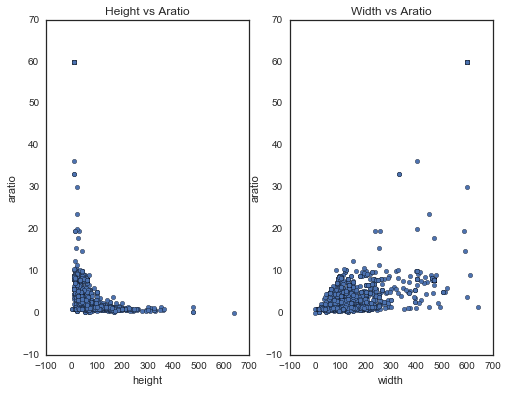

In [28]:
'''
    Relationship between height & aratio, and width & aratio
        - Can't really see much of a relationship, will take log next. 
        - However, it looks like there are a few outliers:
            - aratio ~60 where height is close to 0 and width is close to 600
'''
fig, axes = plt.subplots(figsize=(8, 6), ncols=2)
dat.plot.scatter(x = var[0], y = var[2],ax=axes[0], title = 'Height vs Aratio')
dat.plot.scatter(x = var[1], y = var[2],ax=axes[1], title = 'Width vs Aratio')


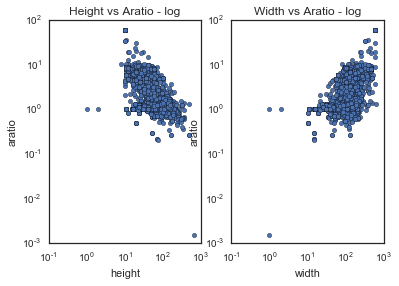

In [30]:
'''
    Let's take the log when plotting to maybe find a relationship? Yes there is.
        As Height increases, Aratio decreases - negative correlation expected
        As Width increases, Aratio increases - positive correlation expected

'''
fig, axes = plt.subplots(figsize=(6, 4), ncols=2)
dat.plot.scatter(x = var[0], y = var[2],ax=axes[0], title = 'Height vs Aratio - log', loglog = True)
dat.plot.scatter(x = var[1], y = var[2],ax=axes[1], title = 'Width vs Aratio - log', loglog = True)


In [31]:
# Remove outliers
dat = dat[dat.aratio < 60]
dat = dat[dat.height != 640]

In [32]:
# look at binary features where there are more 1 values than 0's in columns
vars_binary = binary_counts.index[0:13]
vars_binary

Index([u'local', u'url*images', u'origurl*www.geocities.com',
       u'origurl*geocities.com', u'url*geocities.com',
       u'url*www.geocities.com', u'ancurl*geocities.com',
       u'ancurl*www.geocities.com', u'ancurl*bin', u'origurl*heartland',
       u'origurl*index', u'origurl*index+html', u'ancurl*com'],
      dtype='object')

In [33]:
binary_counts.head()

,0,1,2
local,760.0,2503.0,15.0
url*images,2334.0,944.0,NaN
origurl*www.geocities.com,2672.0,606.0,NaN
origurl*geocities.com,2672.0,606.0,NaN
url*geocities.com,2697.0,581.0,NaN


/usr/local/lib/python2.7/site-packages/pandas/tools/plotting.py:965: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


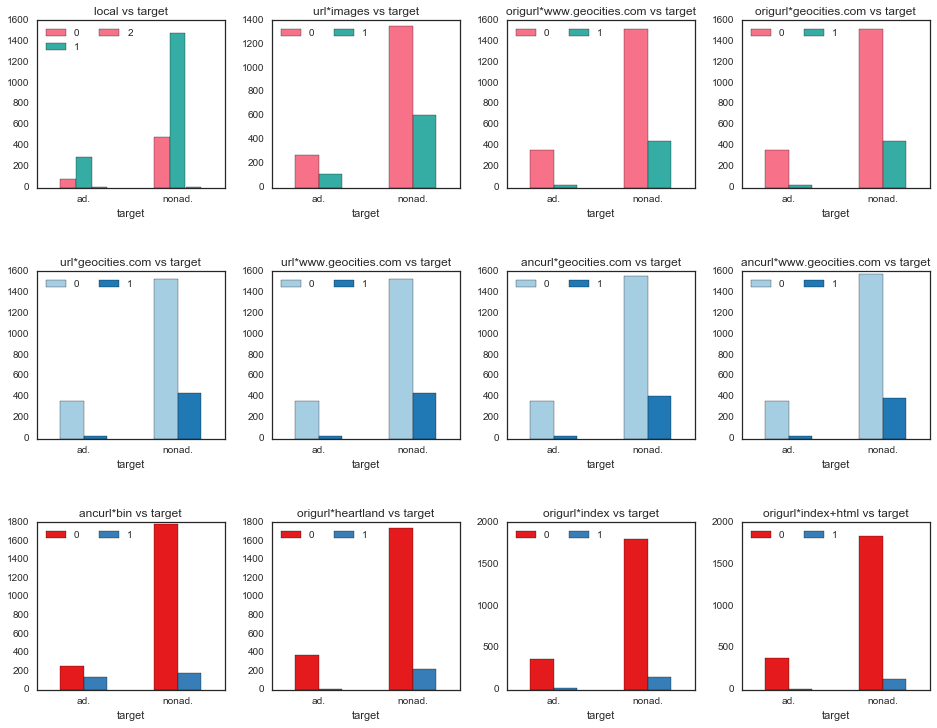

In [34]:
'''
    Plot binary features with more 1's (top ones)
    
    Here we can see from some of the plots that the distributions in the data is the same
    for example these distributions looks the same:
        origurl*www.geocities.com vs Target and origurl*geocities.com vs Target
'''

fig, axes = plt.subplots(ncols=4, nrows=3, figsize = (16,12))
fig.subplots_adjust(hspace=.5, wspace=.25)

for ix, i in enumerate(vars_binary[0:4]):
    dat.groupby(['target'])[i].value_counts().unstack().plot(kind = 'bar', ax=axes[0][ix], 
                                                             colors =sns.color_palette("husl", 2))
    labels = [item.get_text() for item in axes[0][ix].get_xticklabels()]
    axes[0][ix].set_xticklabels(labels, rotation = 0)
    axes[0][ix].set_title(i + str(' vs target'))
    axes[0][ix].legend(loc='best', ncol=2)
for ix, i in enumerate(vars_binary[4:8]):
    dat.groupby(['target'])[i].value_counts().unstack().plot(kind = 'bar', ax=axes[1][ix], 
                                                            colors =sns.color_palette("Paired", 2))
    labels = [item.get_text() for item in axes[1][ix].get_xticklabels()]
    axes[1][ix].set_xticklabels(labels, rotation = 0)
    axes[1][ix].set_title(i + str(' vs target'))
    axes[1][ix].legend(loc='best', ncol=2)
for ix, i in enumerate(vars_binary[8:12]):
    dat.groupby(['target'])[i].value_counts().unstack().plot(kind = 'bar', ax=axes[2][ix], 
                                                            colors =sns.color_palette("Set1", 2))
    labels = [item.get_text() for item in axes[2][ix].get_xticklabels()]
    axes[2][ix].set_xticklabels(labels, rotation = 0)
    axes[2][ix].set_title(i + str(' vs target'))
    axes[2][ix].legend(loc='best', ncol=2)
plt.show(fig)

In [35]:
'''
    Sort the counts by 0 values - these features are almost all 0 so they dont provide much information, 
    but lets look at a few and how they relate to the target
''' 
binary_counts.sort_values(by = 0, ascending=False, inplace=True)

In [36]:
binary_counts.head()

,0,1,2
ancurl*schwab,3274.0,4.0,NaN
caption*you,3273.0,5.0,NaN
ancurl*excite+468x60,3273.0,5.0,NaN
ancurl*cuteftp,3273.0,5.0,NaN
ancurl*slagen,3273.0,5.0,NaN


In [37]:
# The same thing as above for binary variables with majority of value being 0
vars_binary_0 = binary_counts.index[0:13]
vars_binary_0

Index([u'ancurl*schwab', u'caption*you', u'ancurl*excite+468x60',
       u'ancurl*cuteftp', u'ancurl*slagen', u'ancurl*de', u'origurl*hist',
       u'ancurl*bridalinfo', u'ancurl*time+1998', u'ancurl*ad+preferences',
       u'ancurl*any+time', u'ancurl*http+ad', u'origurl*mindlink.net'],
      dtype='object')

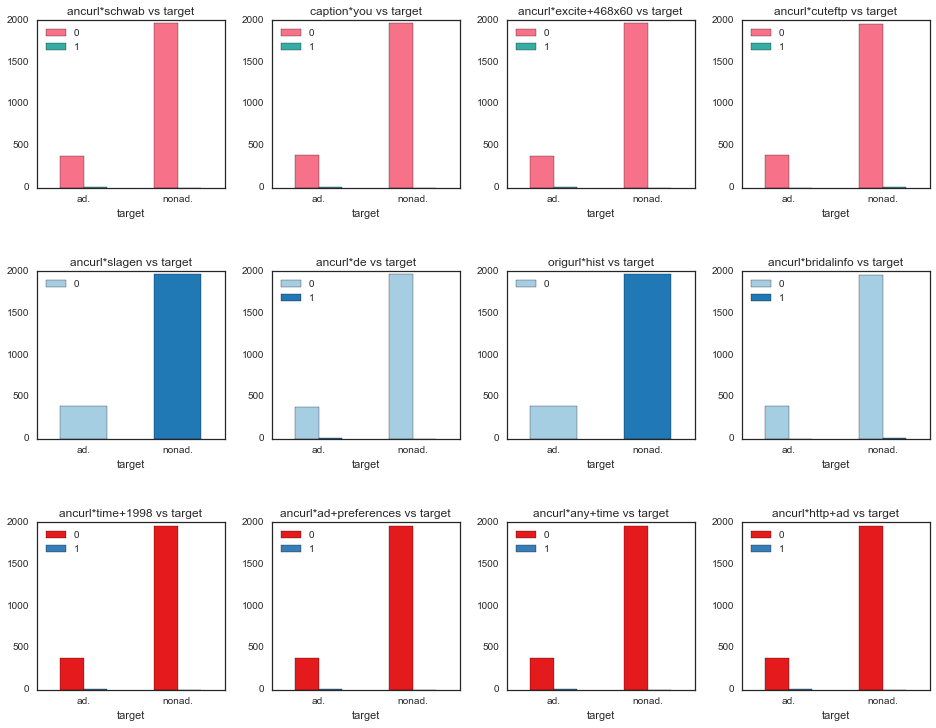

In [38]:
'''
    Plot binary features with more 0's (top ones)
    
    Here we can see from some of the plots that some of the features representing anchor text are all 0
    Maybe these wont be important in the model?
'''

fig, axes = plt.subplots(ncols=4, nrows=3, figsize = (16,12))
fig.subplots_adjust(hspace=.5, wspace=.25)

for ix, i in enumerate(vars_binary_0[0:4]):
    dat.groupby(['target'])[i].value_counts().unstack().plot(kind = 'bar', ax=axes[0][ix], 
                                                             colors =sns.color_palette("husl", 2))
    labels = [item.get_text() for item in axes[0][ix].get_xticklabels()]
    axes[0][ix].set_xticklabels(labels, rotation = 0)
    axes[0][ix].set_title(i + str(' vs target'))
    axes[0][ix].legend(loc='upper left', ncol=1)
for ix, i in enumerate(vars_binary_0[4:8]):
    dat.groupby(['target'])[i].value_counts().unstack().plot(kind = 'bar', ax=axes[1][ix], 
                                                            colors =sns.color_palette("Paired", 2))
    labels = [item.get_text() for item in axes[1][ix].get_xticklabels()]
    axes[1][ix].set_xticklabels(labels, rotation = 0)
    axes[1][ix].set_title(i + str(' vs target'))
    axes[1][ix].legend(loc='upper left', ncol=1)
for ix, i in enumerate(vars_binary_0[8:12]):
    dat.groupby(['target'])[i].value_counts().unstack().plot(kind = 'bar', ax=axes[2][ix], 
                                                            colors =sns.color_palette("Set1", 2))
    labels = [item.get_text() for item in axes[2][ix].get_xticklabels()]
    axes[2][ix].set_xticklabels(labels, rotation = 0)
    axes[2][ix].set_title(i + str(' vs target'))
    axes[2][ix].legend(loc='upper left', ncol=1)
plt.show(fig)

In [39]:
dat[vars_cont].describe()

,height,width,aratio
count,2347.000000,2347.000000,2347.000000
mean,64.081380,151.885812,3.436904
std,53.510392,124.086963,3.131330
min,1.000000,1.000000,0.208300
25%,25.000000,80.000000,1.028500
50%,51.000000,110.000000,2.086900
75%,85.000000,182.500000,5.109350
max,480.000000,640.000000,36.363600


In [40]:
# height and width need to be scaled to the same scale as aratio
# will divide both height & width by 10
vars_scale = ['height','width']
dat[vars_scale] = dat[vars_scale]/10.0

In [41]:
dat[vars_cont].describe()

,height,width,aratio
count,2347.000000,2347.000000,2347.000000
mean,6.408138,15.188581,3.436904
std,5.351039,12.408696,3.131330
min,0.100000,0.100000,0.208300
25%,2.500000,8.000000,1.028500
50%,5.100000,11.000000,2.086900
75%,8.500000,18.250000,5.109350
max,48.000000,64.000000,36.363600


array([<matplotlib.axes._subplots.AxesSubplot object at 0x111248390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x113c3a5d0>], dtype=object)

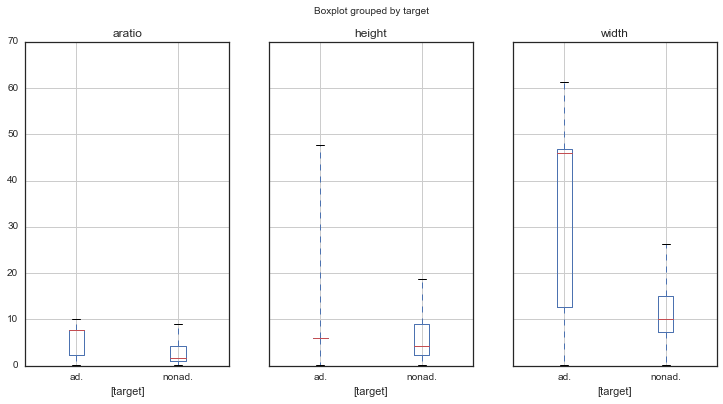

In [42]:
# new boxplot for continuous features
dat[['height','width','aratio','target']].boxplot(by= 'target', figsize = (12,6), layout = (1,3))

## Section 3 - Correlations

In [ ]:
'''
    Correlations
        Looks like many of the features are highly correlated with one another
        And there is correlation among the three continuous variables
'''

In [43]:
corrmat = dat.corr()

In [44]:
# first 100 features - how correlated are they?
# There are quite a few highly correlated features in the data
corr_1 = corrmat.iloc[0:20,0:20]
corr_2 = corrmat.iloc[21:50,21:50]
corr_3 = corrmat.iloc[51:70,51:70]
corr_4 = corrmat.iloc[71:100,71:100]

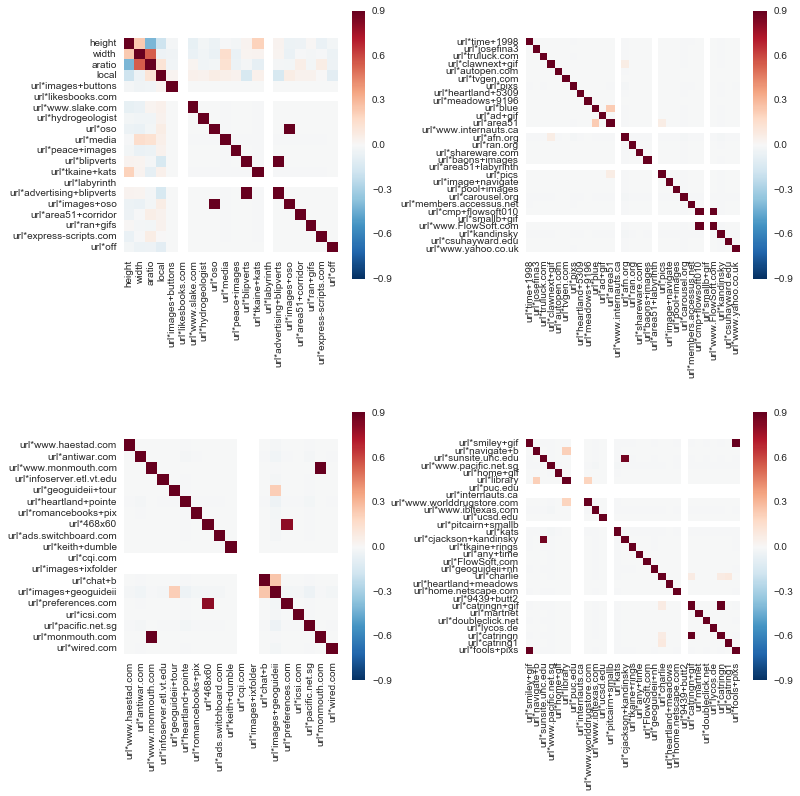

In [45]:
# plot correlation matrix
fig, axes = plt.subplots(figsize=(12, 12), nrows=2, ncols=2)
fig.subplots_adjust(hspace=.5, wspace=.5)
sns.heatmap(corr_1, vmax=.9, square=True, ax=axes[0][0]);
sns.heatmap(corr_2, vmax=.9, square=True, ax=axes[0][1]);
sns.heatmap(corr_3, vmax=.9, square=True, ax=axes[1][0]);
sns.heatmap(corr_4, vmax=.9, square=True, ax=axes[1][1]);

In [46]:
# get indices where correlation > 0.5 and put into a dataframe to take a closer look
indices = np.where(dat.corr().abs() > 0.5)
indices_corr = [(corrmat.index[x], corrmat.columns[y], corrmat.ix[x][y]) for x, y in zip(*indices) if x != y and x < y and (x!=y!=1.0)]

In [47]:
# These features are perfectly correlated with each other
corr_df = pd.DataFrame(indices_corr, columns=['feature_1','feature_2','correlation'])
corr_df.sort_values(['correlation','feature_1'],ascending=False, inplace=True)
corr_df.head(20)

,feature_1,feature_2,correlation
3612,url*zueri.ch,origurl*zueri.ch,1.0
3064,url*yahoo.co.uk,origurl*yahoo.co.uk,1.0
3065,url*yahoo.co.uk,ancurl*www.yahoo.co.uk,1.0
3068,url*yahoo.co.uk,ancurl*ukie,1.0
3069,url*yahoo.co.uk,ancurl*d+ukie,1.0
3071,url*yahoo.co.uk,ancurl*1+d,1.0
3074,url*yahoo.co.uk,ancurl*yahoo.co.uk,1.0
412,url*www.yahoo.co.uk,url*adv+images,1.0
413,url*www.yahoo.co.uk,url*adv,1.0
414,url*www.yahoo.co.uk,url*yahoo.co.uk,1.0


## Exploratory Summary

After doing some exploratory analysis, it is clear that there is are more Non-Ads than Ads in the dataset (84% vs 16%). There are many features in the data, and it looks like a lot of them have majority value equal to 0, so I think
that these may not add much information to the data. Also, there are many features that are highly correlated in the dataset. Since there are so many features in the data, next I will explore PCA to reduce dimensionality and penalized logistic regression. As a last step, I want to also explore random forests since they have embedded feature importance based on Gini impurity/ information gain.

## Section 4 - Models to predict Ad vs Non Ad

### a) PCA and Logistic Regression

In [48]:
# shuffle data
X, y = shuffle(dat.drop(['target'], axis=1), dat.target, random_state=23)

In [49]:
# split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)

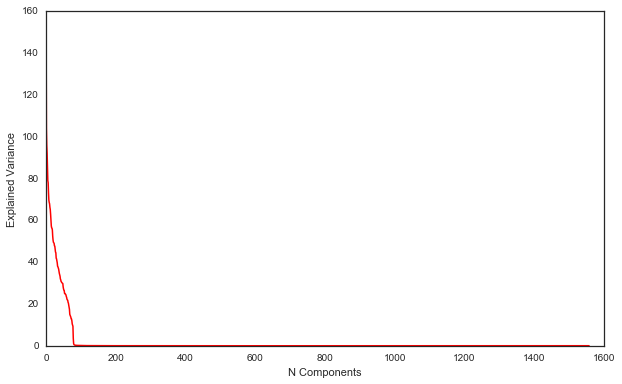

In [50]:
# run PCA to get an idea of how many components are best on all data (for grid search)
# use PCA to reduce dimensionality
pca = decomposition.PCA()

pca.fit(X)

# plot PCA components and explained variance
plt.figure(1, figsize=(10, 6))
plt.plot(pca.explained_variance_, linewidth=1.5, c='red')
plt.xlabel('N Components')
plt.ylabel('Explained Variance')

In [51]:
'''
    Use PCA to reduce dimensionality and then run logistic regression 
'''
# use PCA to reduce dimensionality
pca = decomposition.PCA()

# use logistic regression to predict target
logreg = LogisticRegression()

# build pipeline to combine PCA and Logistic Regression
pipe = Pipeline(steps=[('pca', pca), ('logistic', logreg)])

# n_components for PCA - for gridsearch
n_components = [100, 140, 160, 180]

# logistic regression - for gridsearch
Cs = np.logspace(-4, 4, 3)

# parameters for logistic regression and PCA
params_grid = {
    'logistic__C': Cs,
    'pca__n_components': n_components,
}

# estimator does gridsearch for best n_components and best C value
estimator = GridSearchCV(estimator=pipe, param_grid=params_grid)

# fit estimator
estimator.fit(X_train, y_train)

print estimator.best_params_, estimator.best_score_

{'logistic__C': 1.0, 'pca__n_components': 160} 0.964488636364


In [52]:
# run estimator on test set and get predictions
predictions = estimator.predict(X_test)

In [53]:
# get score
print "Logistic Regression using:", estimator.best_params_['pca__n_components'], "components.\nScore on Test set:", estimator.score(X_test,y_test)

Logistic Regression using: 160 components.
Score on Test set: 0.953191489362


In [54]:
# Classification Report
print "\nClassification Report:\n"
print (classification_report(y_test, predictions))

# Confustion Matrix
print "Confustion Matrix:" 
print(get_confusion_matrix(y_test, predictions))



Classification Report:

             precision    recall  f1-score   support

        ad.       0.96      0.71      0.82        35
     nonad.       0.95      0.99      0.97       200

avg / total       0.95      0.95      0.95       235

Confustion Matrix:
               Ad_Predicted  Non-AD_Predicted
Ad_Actual                25                10
Non-AD_Actual             1               199


### PCA and Logistic Regression Results discussion

While running PCA and Logistic Regression using gridsearch for finding the best parameters took a bit of time, the results are pretty good. Running PCA reduces the dimensinality of the data to 160 features which is not surprising given the exploratory analysis which showed many highly correlated features and features with practically all 0's. Using 90% of the data for training and 10% for testing, the model has a score of 95%. The classification report indicates that the model makes errors when it predicts Ads as Non-Ads, which reduces the recall and F1 scores. 

Next, I am interested in running Logistic Regression using L1 penalty to reduce the coefficients to zero for feature selection.

### b) Logistic Regression using L1 penalty

In [55]:
'''
    Logistic Regression using L1 penalty which automatically does feature selection
'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=2)

params_grid_1 = {'C': Cs,}
# use L1 penalty
logreg_L1 = LogisticRegression(penalty='l1')
# perform grid search for best C value
estimator_L1 = GridSearchCV(estimator=logreg_L1, param_grid=params_grid_1)
# train model
estimator_L1.fit(X_train, y_train)
# print score on training set
print estimator_L1.best_params_, estimator_L1.best_score_

{'C': 1.0} 0.96259469697


In [56]:
# run L1 Logistic Regression estimator on test set and get predictions
predictions_L1 = estimator_L1.predict(X_test)

In [57]:
# get score
print "Logistic Regression with L1 penalty score on Test set:", estimator_L1.score(X_test,y_test)

Logistic Regression with L1 penalty score on Test set: 0.978723404255


In [58]:
# Classification Report
print "\nClassification Report:\n"
print (classification_report(y_test, predictions_L1))

# Confustion Matrix
print "Confustion Matrix:" 
print(get_confusion_matrix(y_test, predictions_L1))



Classification Report:

             precision    recall  f1-score   support

        ad.       1.00      0.88      0.93        40
     nonad.       0.97      1.00      0.99       195

avg / total       0.98      0.98      0.98       235

Confustion Matrix:
               Ad_Predicted  Non-AD_Predicted
Ad_Actual                35                 5
Non-AD_Actual             0               195


In [59]:
# Top 20 coefficients
l1_coefs = pd.DataFrame(data = zip(feature_names, estimator_L1.best_estimator_.coef_.tolist()[0]), columns = ['feature','coef']).sort_values(by='coef', ascending=False)
l1_coefs.head(15)

,feature,coef
1021,ancurl*news,4.572085
1458,alt*information,3.359461
1009,ancurl*bin+click,2.840325
499,origurl*www.news-observer.com,1.987307
766,origurl*news-observer.com,1.742021
455,url*geoguideii,0.843380
1314,ancurl*www.news-observer.com,0.806326
1388,ancurl*news-observer.com,0.803302
1531,alt*about,0.801279
1462,alt*to,0.768667


## Logistic Regression using L1 penalty Results discussion

The score for logistic regression using L1 penalty is close to 98%, so it is better than that of PCA + Logistic Regression. Also, the above model misses fewer times when predicting an Ad as a Non-Ad, and thus has a higer F1 score.
The model does feature selection by shrinking coefficients down to 0 for features that dont explain the data well. When looking at the features with highest coefficients sorted in decreasing order, we can see that 'ancurl news' is at the top along with 'alt information'. 

Lasty, I want to explore feature importance using a Random Forest Classifier in order to compare features importances and scores.

### c) Random Forest Classifier 

In [60]:
'''
FEATURE IMPORTANCE USING Random Forest Classifier
'''
# split data into training and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.10, random_state=3)

# Random Forest Classifer
rf = RandomForestClassifier(n_estimators = 1500)
rf.fit(X_train, y_train)
print "Random Forest classifier score on training set", rf.score(X_train, y_train)
rf_predicted = rf.predict(X_test)
print "Random Forest classifier score on test set", rf.score(X_test, y_test)


Random Forest classifier score on training set 0.999526515152
Random Forest classifier score on test set 0.970212765957


In [61]:
# Classification Report
print "\nClassification Report:\n"
print (classification_report(y_test, rf_predicted))

# Confustion Matrix
print "Confustion Matrix:" 
print(get_confusion_matrix(y_test, rf_predicted))


Classification Report:

             precision    recall  f1-score   support

        ad.       0.97      0.83      0.90        36
     nonad.       0.97      0.99      0.98       199

avg / total       0.97      0.97      0.97       235

Confustion Matrix:
               Ad_Predicted  Non-AD_Predicted
Ad_Actual                30                 6
Non-AD_Actual             1               198


### Random Forest Classifier Results discussion
The performance of the Random Forest Classifier is not as good as that of Logistic Resgression using L1 penalty (98% vs. 97%) but it is very close to that of PCA + Logistic Regression. The top features (based on importance) are not the same as those with the highest coefficients which makes sense given that one is optimizing based on feature impurity while the other is not.


## Final thoughts

In conclusion, I went through a few algorithms to predict if an image will be an advertisement or not based on its attributes, and all of these predicted with over 90% accuracy on the test set. If I had to chose, I would implement Logistic Regression with L1 penalty because it scored the highest and reduced the dimensionality in the dataset which is important when dealing with so many features. However, I also think the Random Forest model also performed very well and did not need much tuning, so it could also be implemented.
